<a href="https://colab.research.google.com/github/leadbreak/paper_review/blob/main/StyleGan_applications_01_toonize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Toonify YourSelf Review
reference : https://www.justinpinkney.com/toonify-yourself/

- Transfer learning을 이용해 사람의 얼굴 사진을 디즈니, 픽사 등의 애니메이션 캐릭터로 변환
- 이후 이렇게 만든 styleGan 모델을 지구의 사진을 만들어주는 styleGan 모델과 layer를 ensemble하는 방식으로 개선해보고자 함.

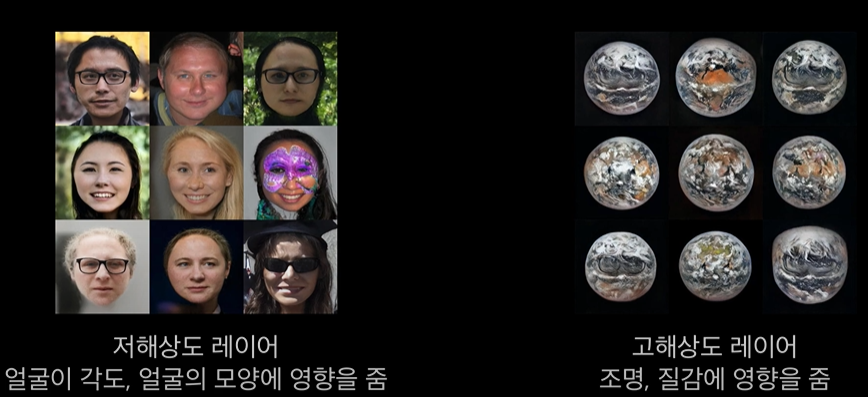

ㄴ이미지 출처 : 유튜브 빵형의 개발도상국(https://www.youtube.com/watch?v=84EqhSY-n6c)

- 기존의 StyleGan을 활용한 얼굴 생성 모델로 얼굴의 핵심 특성을 압축하여 표현하는 압축 벡터(Latent Vector)를 추출하도록 학습시키고, 이를 이용한 카툰화

#Code

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
GPU says hello.


In [3]:
!mkdir raw
!mkdir aligned
!mkdir generated

mkdir: cannot create directory ‘raw’: File exists
mkdir: cannot create directory ‘aligned’: File exists
mkdir: cannot create directory ‘generated’: File exists


## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [22]:
# 공개적으로 공개된 이미지 같은 경우 wget으로 편하게 가져오고, 그 외의 경우 생성한 작업 폴더에 업로드 후 작업
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example.jpg
!wget https://image.bugsm.co.kr/artist/images/1000/800491/80049126.jpg -O raw/iu_00.jpg

--2021-02-24 07:56:09--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>] 324.91K  --.-KB/s    in 0.02s   

2021-02-24 07:56:09 (16.2 MB/s) - ‘raw/example.jpg’ saved [332712/332712]

--2021-02-24 07:56:09--  https://image.bugsm.co.kr/artist/images/1000/800491/80049126.jpg
Resolving image.bugsm.co.kr (image.bugsm.co.kr)... 101.79.244.226, 183.111.25.33
Connecting to image.bugsm.co.kr (image.bugsm.co.kr)|101.79.244.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502923 (491K) [image/jpeg]
Saving to: ‘raw/iu_00.jpg’

raw/iu_00.jpg       100%[===================>] 491.14K   187KB/s    in 2.

In [ ]:
# 공개되지 않은 이미지를 따로 업로드

from google.colab import files

files.upload()

In [23]:
!ls

aligned		       grid_vid.py	       README.md
align_images.py        IU_01.jpg	       run_generator.py
blend_models.py        IU_02.jpg	       run_metrics.py
dataset_tool.py        LICENSE.txt	       run_projector.py
dnnlib		       metrics		       run_training.py
Dockerfile	       pretrained_networks.py  stylegan2
docs		       project_images.py       test_nvcc
fake_art_portrait.jpg  projector.py	       test_nvcc.cu
ffhq_dataset	       __pycache__	       training
generated	       raw


In [24]:
!mv IU_01.jpg raw/
!mv IU_02.jpg raw/
!ls

aligned		 fake_art_portrait.jpg	 project_images.py  run_projector.py
align_images.py  ffhq_dataset		 projector.py	    run_training.py
blend_models.py  generated		 __pycache__	    stylegan2
dataset_tool.py  grid_vid.py		 raw		    test_nvcc
dnnlib		 LICENSE.txt		 README.md	    test_nvcc.cu
Dockerfile	 metrics		 run_generator.py   training
docs		 pretrained_networks.py  run_metrics.py


##Load Pretrained Models

In [25]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

##Align Faces

In [26]:
!python align_images.py raw aligned # 얼굴이 기울어진 사진일 경우 똑바로 세운다

##Extract Latent Vector from Aligned Face

In [27]:
!python project_images.py --num-steps 1000 aligned generated # 1000번 학습 시켜서 핵심 특징(Latent Vector)을 추출

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "IU_01_01.png"...
0 / 1000 ... 2021-02-24 07:57:17.921443: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GAR

##Get Result from Blended Model

In [28]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


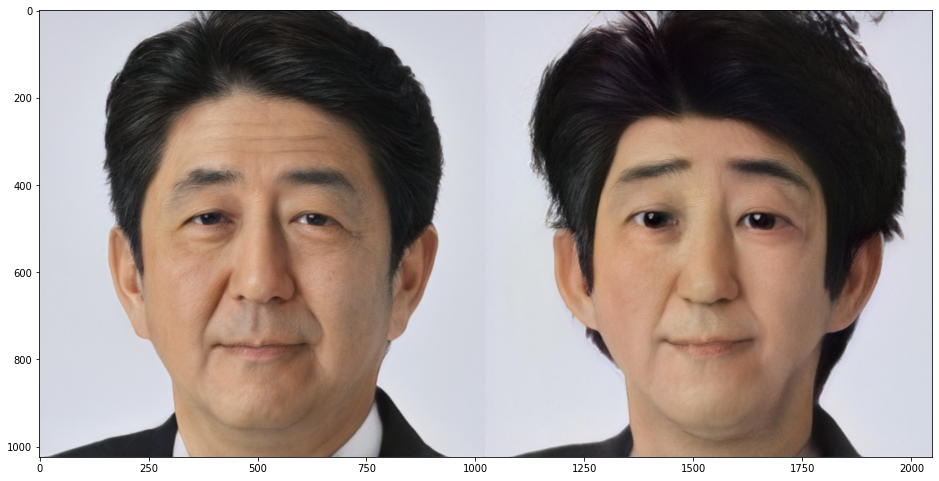

In [29]:
from PIL import Image
import matplotlib.pyplot as plt

embedded = Image.open("generated/example_01.png")
tooned = Image.open("generated/example_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

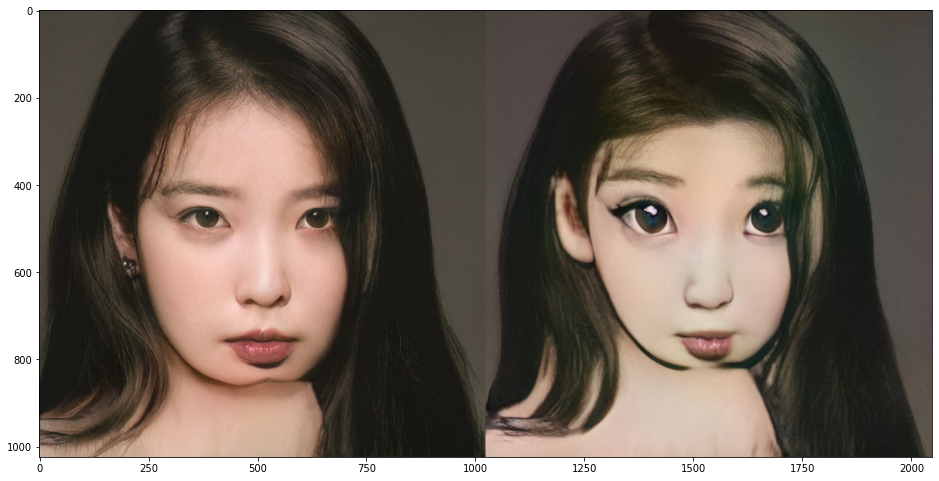

In [30]:
embedded = Image.open("generated/iu_00_01.png")
tooned = Image.open("generated/iu_00_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

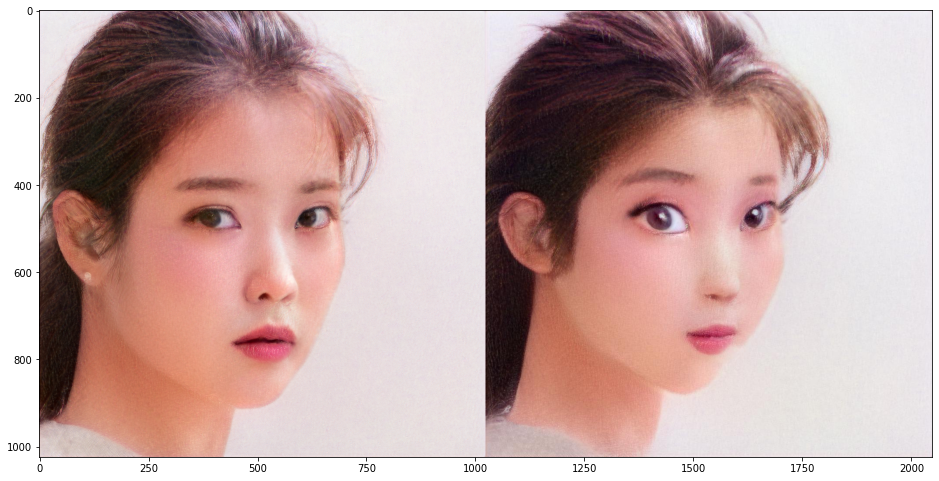

In [31]:
embedded = Image.open("generated/IU_01_01.png")
tooned = Image.open("generated/IU_01_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))

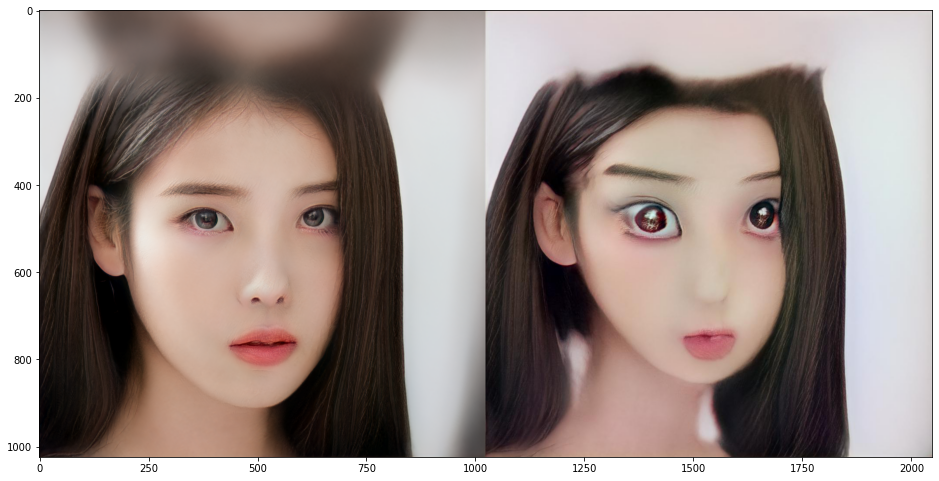

In [32]:
embedded = Image.open("generated/IU_02_01.png")
tooned = Image.open("generated/IU_02_01-toon.jpg")

plt.figure(figsize=(16, 10))
plt.imshow(np.concatenate([np.array(embedded), np.array(tooned)], axis=1))